In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import random

## Rationale
Predictive maintenance techniques use data analysis tools to help determine the condition of in-service equipment or detect anomalies in processes and thus estimating when maintenance should be performed before they result in failure. Predictive maintenance deals with prediction of remaining useful life (RUL), which is the number of the loading cycles that a component of a machine is estimated to be able to function as intended. 

Predictive maintenance have tremendous advantages in all machine components that undergoes wear and tear during operation. Accurate prediction of remaining useful helps maximizing machine lifespan and minimizing planned downtime which leads to significant a cost-savings.  Additionally, it is very important aspect from safety point of view, as it prevents catastrophic failure of the machine component especially in the aerospace industry.

## Research Question

This is a time series regression problem i.e. predicting a future response based on the history of response and relevant predictors and the dynamics between them. Remaining useful life (RUL) for an engine is predicted using advanced machine learning techniques using neural networks including temporal convolution layers and LSTM layers to account for the tempral relationship between features and the target. 

The current analysis aims to replicate the model presented in the this paper - https://arxiv.org/abs/1810.05644. 


## Dataset Info

Publicly available NASA Commercial Modular AeroPropulsion System Simulation dataset (C-MAPSS) is chosen for this analysis. C-MAPSS dataset consists of 4 sub-datasets, with different operating and fault conditions, leading to complex relations with sensors. In every sub-dataset, training trajectories are concatenated along the temporal axis, and same applies for the testing trajectories as well.

The scope for this analysis is limited to Dataset FD001 with only one fault condition. This dataset contains data from 100 Engine IDs each in train and test set for various loading cycles. For all Engine IDs, there is 3 settings and 21 sensors information at each loading cycle which can be used as features.

#### Train Set
* All engines were run till failure. 

* So the RUL value can be calculated at each cycle by substracting the cycle number from the maximum cycle number for the engine. 

#### Test Set
* For all engines, the sensor information is available for a certain number of loading cycles in test_FD001.txt file and the RUL at the end of that cycle all provided in the RUL_FD001.txt.

* So the RUL value can be calculated at each loading cycle by substracting the cycle number from the maximum cycle number for the engine and adding the RUL value for the engine from RUL_FD001.txt.

#### MAX Life
* However, there is a maximum limit to the RUL at any loading cycle (MAXLIFE). Hence, typical variation in RUL with loading cycles follows a Piecewise linear function with zero gradient and unit gradient.

In [ ]:
### Variation in RUL with loading cycles
'''
        ^
        |
MAXLIFE |-----------
        |            \
        |             \
        |              \
        |               \
        |                \
        |----------------------->

'''

## Import Data and Preliminary Analysis

In [3]:
column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [4]:
## Read train Data
train_FD001 = pd.read_table("./CMAPSSData/train_FD001.txt", header=None, delim_whitespace=True)
train_FD001.columns = column_names
print('Train Set size: ',train_FD001.shape, ', Number of distinct Engine IDs:', len(train_FD001.engine_id.unique()))
train_FD001.head()

Train Set size:  (20631, 26) , Number of distinct Engine IDs: 100


,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
train_FD001.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   engine_id  20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   setting1   20631 non-null  float64
 3   setting2   20631 non-null  float64
 4   setting3   20631 non-null  float64
 5   s1         20631 non-null  float64
 6   s2         20631 non-null  float64
 7   s3         20631 non-null  float64
 8   s4         20631 non-null  float64
 9   s5         20631 non-null  float64
 10  s6         20631 non-null  float64
 11  s7         20631 non-null  float64
 12  s8         20631 non-null  float64
 13  s9         20631 non-null  float64
 14  s10        20631 non-null  float64
 15  s11        20631 non-null  float64
 16  s12        20631 non-null  float64
 17  s13        20631 non-null  float64
 18  s14        20631 non-null  float64
 19  s15        20631 non-null  float64
 20  s16   

In [6]:
train_FD001.drop(['engine_id', 'cycle'], axis = 1).describe()

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [7]:
## Read Test Data
test_FD001 = pd.read_table("./CMAPSSData/test_FD001.txt", header=None, delim_whitespace=True)
test_FD001.columns = column_names
# load RUL data for Test
RUL_FD001 = pd.read_table("./CMAPSSData/RUL_FD001.txt", header=None, delim_whitespace=True)
RUL_FD001.columns = ['RUL']

print('Test Set size: ',test_FD001.shape, 
        ', Number of distinct Engine IDs:', len(test_FD001.engine_id.unique()),
        ', RUL info for each Engine ID', len(RUL_FD001.notnull()))

print(RUL_FD001.head())
test_FD001.head()

Test Set size:  (13096, 26) , Number of distinct Engine IDs: 100 , RUL info for each Engine ID 100
   RUL
0  112
1   98
2   69
3   82
4   91


,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [8]:
test_FD001.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   engine_id  13096 non-null  int64  
 1   cycle      13096 non-null  int64  
 2   setting1   13096 non-null  float64
 3   setting2   13096 non-null  float64
 4   setting3   13096 non-null  float64
 5   s1         13096 non-null  float64
 6   s2         13096 non-null  float64
 7   s3         13096 non-null  float64
 8   s4         13096 non-null  float64
 9   s5         13096 non-null  float64
 10  s6         13096 non-null  float64
 11  s7         13096 non-null  float64
 12  s8         13096 non-null  float64
 13  s9         13096 non-null  float64
 14  s10        13096 non-null  float64
 15  s11        13096 non-null  float64
 16  s12        13096 non-null  float64
 17  s13        13096 non-null  float64
 18  s14        13096 non-null  float64
 19  s15        13096 non-null  float64
 20  s16   

In [9]:
test_FD001.drop(['engine_id', 'cycle'], axis = 1).describe()

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,13096.000000,13096.000000,13096.0,1.309600e+04,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.000000,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,-0.000011,0.000004,100.0,5.186700e+02,642.475088,1588.099204,1404.735362,1.462000e+01,21.609701,553.757523,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,0.002203,0.000294,0.0,6.014263e-11,0.400899,5.003274,6.688309,2.671743e-12,0.001704,0.681286,...,0.559627,0.056934,10.188605,0.029009,8.823140e-15,1.233577,0.0,0.0,0.141681,0.084120
min,-0.008200,-0.000600,100.0,5.186700e+02,641.130000,1569.040000,1384.390000,1.462000e+01,21.600000,550.880000,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,-0.001500,-0.000200,100.0,5.186700e+02,642.197500,1584.600000,1399.950000,1.462000e+01,21.610000,553.310000,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,-0.000000,-0.000000,100.0,5.186700e+02,642.460000,1587.990000,1404.440000,1.462000e+01,21.610000,553.800000,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,0.001500,0.000300,100.0,5.186700e+02,642.740000,1591.362500,1409.050000,1.462000e+01,21.610000,554.240000,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,0.007800,0.000700,100.0,5.186700e+02,644.300000,1607.550000,1433.360000,1.462000e+01,21.610000,555.840000,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


## Observations:

* There are no null values in the datasets. 

* There is data for 100 different Engine IDs in training and test set. 

* The range of features vary a lot, hence standard or min-max scaling needs to applied.

* Data needs to be processed to have the 'RUL' value at each loading cycle (row) for regression analysis.


## Data Processing

In [10]:
### Helper function for processing data
def kink_RUL(cycle_list, max_cycle):
    '''
    Piecewise linear function with zero gradient and unit gradient
            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    stable_life = MAXLIFE
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - (stable_life / (max_cycle - knee_point))
            kink_RUL.append(tmp)

    return kink_RUL

def compute_rul_of_one_id(FD00X_of_one_id, max_cycle_rul=None):
    '''
    Enter the data of an engine_id of train_FD001 and output the corresponding RUL (remaining life) of these data.
    type is list
    '''

    cycle_list = FD00X_of_one_id['cycle'].tolist()
    if max_cycle_rul is None:
        max_cycle = max(cycle_list)  # Failure cycle
    else:
        max_cycle = max(cycle_list) + max_cycle_rul
        # print(max(cycle_list), max_cycle_rul)

    # return kink_RUL(cycle_list,max_cycle)
    return kink_RUL(cycle_list, max_cycle)


def compute_rul_of_one_file(FD00X, id='engine_id', RUL_FD00X=None):
    '''
    Input train_FD00X file, output a list
    '''
    rul = []
    # In the loop train, each id value of the 'engine_id' column
    if RUL_FD00X is None:
        for _id in set(FD00X[id]):
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id]))
        return rul
    else:
        rul = []
        for _id in set(FD00X[id]):
            # print("#### id ####", int(RUL_FD00X.iloc[_id - 1]))
            # true_rul.append(int(RUL_FD00X.iloc[_id - 1]))
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id], int(RUL_FD00X.iloc[_id - 1])))
        return rul

In [11]:
## Process Train Data
files=[1]
min_max_norm=False
true_rul = []
frames = []
previous_len = 0
MAXLIFE = 120

## Loop over subdatasets
for data_file in ['train_FD00' + str(i) for i in files]:  # load subdataset by subdataset

    #### standard normalization ####
    mean = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].mean()
    std = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].std()
    std.replace(0, 1, inplace=True)

    if min_max_norm:
        scaler = MinMaxScaler()
        eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = scaler.fit_transform(
            eval(data_file).iloc[:, 2:len(list(eval(data_file)))])
    else:
        eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = (eval(data_file).iloc[:, 2:len(
            list(eval(data_file)))] - mean) / std

    eval(data_file)['RUL'] = compute_rul_of_one_file(eval(data_file))
    current_len = len(eval(data_file))
    # print(eval(data_file).index)
    eval(data_file).index = range(previous_len, previous_len + current_len)
    previous_len = previous_len + current_len
    # print(eval(data_file).index)
    frames.append(eval(data_file))
    print(data_file)

train = pd.concat(frames)

global training_engine_id
training_engine_id = train['engine_id']

## Write processed data to csv and numpyarray
train_values = train.drop(['engine_id','cycle'] , axis = 1).values
np.save('Processed_Data/FD001_normalized_train_data.npy', train_values)
train.to_csv('Processed_Data/FD001_normalized_train_data.csv', index = False)

train_FD001


In [12]:
## Process Test Data

## Loop over subdatasets
for (data_file, rul_file) in [('test_FD00' + str(i), 'RUL_FD00' + str(i)) for i in files]:
    mean = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].mean()
    std = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].std()
    std.replace(0, 1, inplace=True)

    if min_max_norm:
        scaler = MinMaxScaler()
        eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = scaler.fit_transform(
            eval(data_file).iloc[:, 2:len(list(eval(data_file)))])
    else:
        eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = (eval(data_file).iloc[:, 2:len(
            list(eval(data_file)))] - mean) / std

    eval(data_file)['RUL'] = compute_rul_of_one_file(eval(data_file), RUL_FD00X=eval(rul_file))
    current_len = len(eval(data_file))
    eval(data_file).index = range(previous_len, previous_len + current_len)
    previous_len = previous_len + current_len
    frames.append(eval(data_file))
    print(data_file)
    if len(files) == 1:
        global test_engine_id
        test_engine_id = eval(data_file)['engine_id']

test = pd.concat(frames)

## Write processed data to csv and numpyarray
test_values = test.drop(['engine_id','cycle'], axis = 1).values
np.save('Processed_Data/FD001_normalized_test_data.npy', test_values)
test.to_csv('Processed_Data/FD001_normalized_test_data.csv', index = False)

test_FD001


In [13]:
## Train Data Augmentation
'''
Training data always run to a failure. But testing data is mostly stop before a failure.
Therefore, training data augmented to have scenarios without failure
'''

files=1
low=[10, 35, 50, 70, 90, 110] #, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330]
high=[35, 50, 70, 90, 110, 130] #, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350]
plot=1

### Loading original data ###     
file_path = "./CMAPSSData/train_FD00" + str(files) + ".txt"
train_FD00x = pd.read_table(file_path, header=None, delim_whitespace=True)
train_FD00x.columns = column_names
print(file_path.split("/")[-1])

### Standered Normal ###
mean = train_FD00x.iloc[:, 2:len(list(train_FD00x))].mean()
std = train_FD00x.iloc[:, 2:len(list(train_FD00x))].std()
std.replace(0, 1, inplace=True)
train_FD00x.iloc[:, 2:len(list(train_FD00x))] = (train_FD00x.iloc[:, 2:len(list(train_FD00x))] - mean) / std

final_train_FD = train_FD00x.copy()
previous_len = 0
frames = []
for i in range(len(high)):
    train_FD = train_FD00x.copy()
    train_engine_id = train_FD['engine_id']
    engine_ids = train_engine_id.unique()
    total_ids = len(engine_ids)
    train_rul = []
    print("*************", final_train_FD.shape, total_ids, low[i], high[i], "*****************")

    for id in range(1, total_ids + 1):

        train_engine_id = train_FD['engine_id']
        indexes = train_engine_id[train_engine_id == id].index  ### filter indexes related to id
        traj_data = train_FD.loc[indexes]  ### filter trajectory data

        cutoff_cycle = random.randint(low[i], high[i])  ### randomly selecting the cutoff point of the engine cycle

        if cutoff_cycle > max(traj_data['cycle']):
            cutoff_cycle = max(traj_data['cycle'])

        train_rul.append(max(traj_data['cycle']) - cutoff_cycle)  ### collecting remaining cycles

        cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index  ### cutoff cycle index

        ### removing rows after cutoff cycle index ###
        if cutoff_cycle_index[0] != indexes[-1]:
            drop_range = list(range(cutoff_cycle_index[0] + 1, indexes[-1] + 1))
            train_FD.drop(train_FD.index[drop_range], inplace=True)
            train_FD.reset_index(drop=True, inplace=True)

    ### calculating the RUL for augmented data
    train_rul = pd.DataFrame.from_dict({'RUL': train_rul})
    train_FD['RUL'] = compute_rul_of_one_file(train_FD, RUL_FD00X=train_rul)

    ### changing the engine_id for augmented data
    train_engine_id = train_FD['engine_id']
    for id in range(1, total_ids + 1):
        indexes = train_engine_id[train_engine_id == id].index
        train_FD.loc[indexes, 'engine_id'] = id + total_ids * (i + 1)

    if i == 0:  # should only execute at the first iteration
        final_train_FD['RUL'] = compute_rul_of_one_file(final_train_FD)
        current_len = len(final_train_FD)
        final_train_FD.index = range(previous_len, previous_len + current_len)
        previous_len = previous_len + current_len

    ### Re-indexing the augmented data
    train_FD['RUL'].index = range(previous_len, previous_len + len(train_FD))
    previous_len = previous_len + len(train_FD)

    final_train_FD = pd.concat(
        [final_train_FD, train_FD])  # concatanete the newly augmented data with previous data

frames.append(final_train_FD)
train = pd.concat(frames)
train.reset_index(drop=True, inplace=True)

train_engine_id = train['engine_id']
# print(train_engine_id)
engine_ids = train_engine_id.unique()
# print(engine_ids[1:])
np.random.shuffle(engine_ids)
# print(engine_ids)

training_data = train.loc[train_engine_id[train_engine_id == engine_ids[0]].index]
training_data.reset_index(drop=True, inplace=True)
previous_len = len(training_data)
for id in engine_ids[1:]:
    traj_data = train.loc[train_engine_id[train_engine_id == id].index]
    current_len = len(traj_data)
    traj_data.index = range(previous_len, previous_len + current_len)
    previous_len = previous_len + current_len
    training_data = pd.concat([training_data, traj_data])

global training_engine_id
training_engine_id = training_data['engine_id']

## Write processed data to csv and numpyarray
training_data_values = training_data.drop(['engine_id', 'cycle'], axis = 1).values 
np.save('Processed_Data/FD001_normalized_train_data_Aug.npy', training_data_values)
training_data.to_csv('Processed_Data/FD001_normalized_train_data_Aug.csv', index = False)

train = training_data_values
x_train = train[:, :train.shape[1] - 1]
y_train = train[:, train.shape[1] - 1] 
print("Augmented train data size: ", x_train.shape, y_train.shape)
print('Number of Engine IDs in the Augmented train set: ', len(engine_ids))

train_FD001.txt
************* (20631, 26) 100 10 35 *****************
************* (22861, 27) 100 35 50 *****************
************* (27098, 27) 100 50 70 *****************
************* (33083, 27) 100 70 90 *****************
************* (40990, 27) 100 90 110 *****************
************* (51035, 27) 100 110 130 *****************
Augmented train data size:  (63047, 24) (63047,)
Number of Engine IDs in the Augmented train set:  700


## Observations:
* Train and test set were successfully processed to calculate RUL value at each loading cycle (row). 

* Training data always run to a failure. But testing data is mostly stop before a failure. Therefore, training data is augmented to have scenarios without failure.

* After augmentation, the train data size is:  (63188, 24) (63188,)

* Number of Engine IDs in the Augmented train set: 700

## Data Analysis and Visualizations

In [14]:
train = pd.read_csv('Processed_Data/FD001_normalized_train_data.csv')
aug_train = pd.read_csv('Processed_Data/FD001_normalized_train_data_Aug.csv')
test = pd.read_csv('Processed_Data/FD001_normalized_test_data.csv')

x_train = train.drop(['RUL'], axis=1) #.set_index(['engine_id', 'cycle'])
y_train = train[['engine_id', 'cycle', 'RUL']]

x_test = test.drop(['RUL'], axis=1) #.set_index(['engine_id', 'cycle'])
y_test = test[['engine_id', 'cycle', 'RUL']]


### Training Data

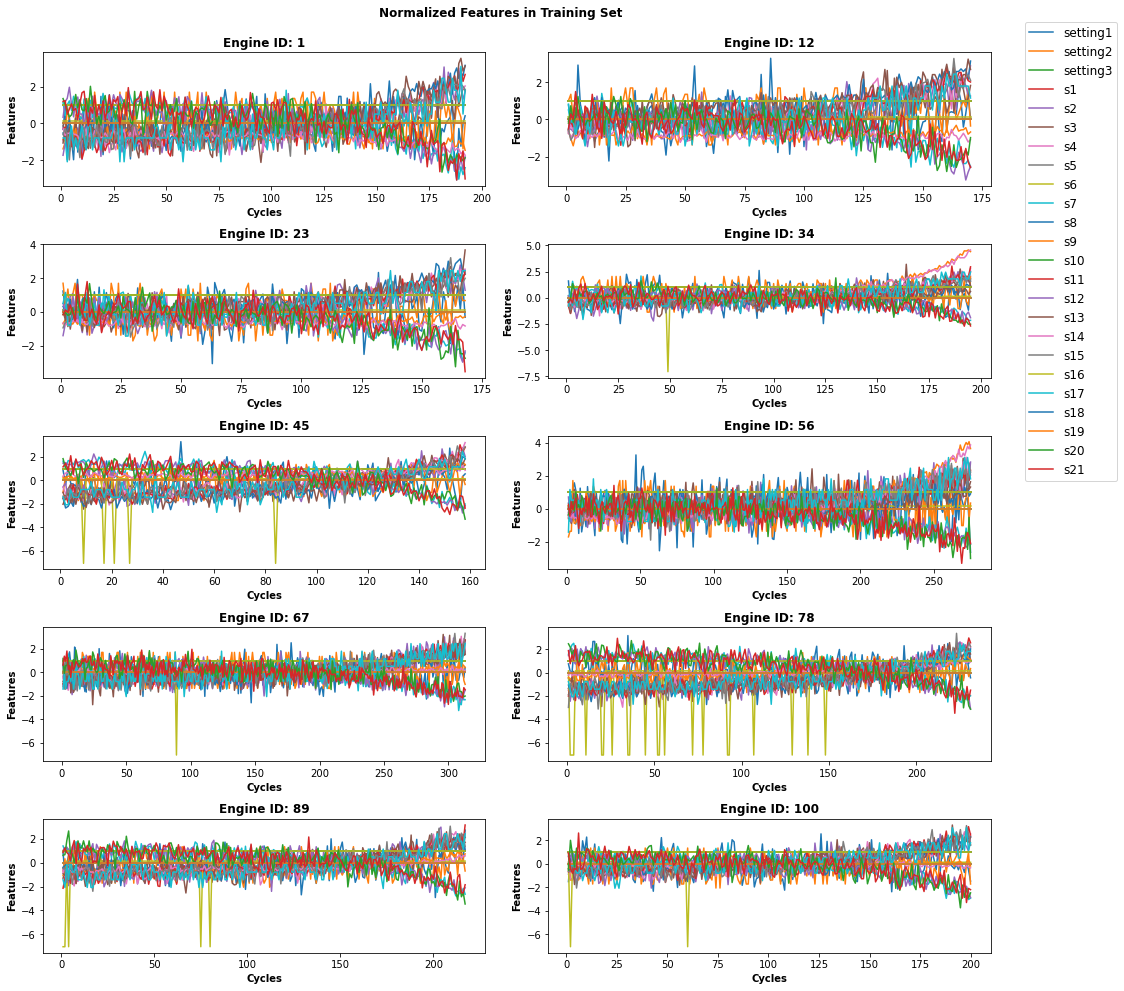

In [15]:
from itertools import islice
fig, ax = plt.subplots(5, 2, figsize=(3.5 * 4, 3.5 * 4))
fax =  ax.ravel()
i=0; k=0
for label, df in x_train.set_index('cycle').groupby('engine_id'):
    if i % 11 == 0:
        df.drop(['engine_id'], axis = 1).plot(ax=fax[k], legend=False)
        fax[k].set_title('Engine ID: {}'.format(label), fontsize=12, fontweight = 'bold')
        fax[k].set_xlabel('Cycles', fontsize=10, fontweight = 'bold')
        fax[k].set_ylabel('Features', fontsize=10, fontweight = 'bold')
        k+=1
    i+=1

plt.suptitle("Normalized Features in Training Set\n", fontsize=12, fontweight = 'bold')
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.3, 7), fontsize=12)
plt.show()

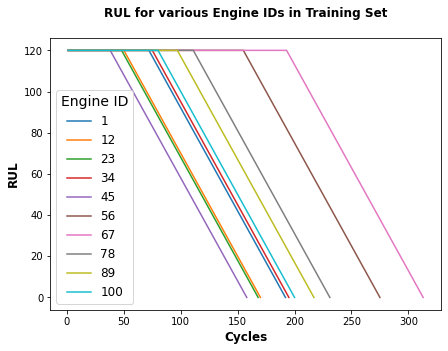

In [16]:
from itertools import islice
fig, ax = plt.subplots(figsize=(7,5))
i=0
for label, df in y_train.groupby('engine_id'):
    if i % 11 == 0:
        df.plot('cycle', 'RUL', ax=ax, label=label)
    i+=1

plt.title("RUL for various Engine IDs in Training Set\n", fontsize=12, fontweight = 'bold')
plt.xlabel('Cycles', fontsize=12, fontweight = 'bold')
plt.ylabel('RUL', fontsize=12, fontweight = 'bold')
plt.legend(fontsize=12, title="Engine ID", title_fontsize=14)
plt.show()


### Test Data

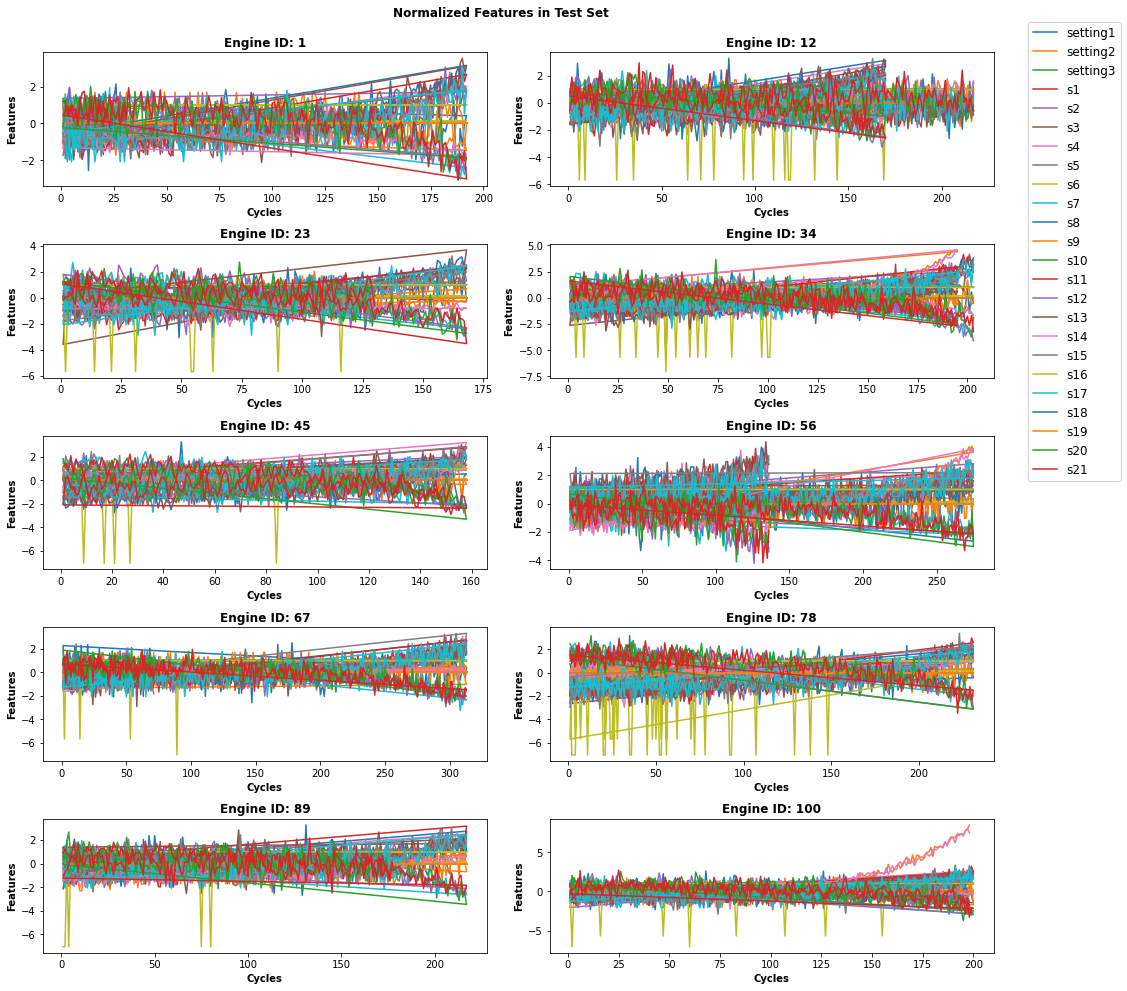

In [17]:
from itertools import islice
fig, ax = plt.subplots(5, 2, figsize=(3.5 * 4, 3.5 * 4))
fax =  ax.ravel()
i=0; k=0
for label, df in x_test.set_index('cycle').groupby('engine_id'):
    if i % 11 == 0:
        df.drop(['engine_id'], axis = 1).plot(ax=fax[k], legend=False)
        fax[k].set_title('Engine ID: {}'.format(label), fontsize=12, fontweight = 'bold')
        fax[k].set_xlabel('Cycles', fontsize=10, fontweight = 'bold')
        fax[k].set_ylabel('Features', fontsize=10, fontweight = 'bold')
        k+=1
    i+=1

plt.suptitle("Normalized Features in Test Set\n", fontsize=12, fontweight = 'bold')
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.3, 7), fontsize=12)
plt.show()

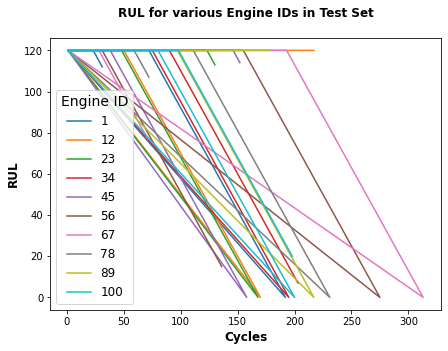

In [18]:
from itertools import islice
fig, ax = plt.subplots(figsize=(7,5))
i=0
for label, df in y_test.groupby('engine_id'):
    if i % 11 == 0:
        df.plot('cycle', 'RUL', ax=ax, label=label)
    i+=1

plt.title("RUL for various Engine IDs in Test Set\n", fontsize=12, fontweight = 'bold')
plt.xlabel('Cycles', fontsize=12, fontweight = 'bold')
plt.ylabel('RUL', fontsize=12, fontweight = 'bold')
plt.legend(fontsize=12, title="Engine ID", title_fontsize=14)
plt.show()

### Augmented Training Data

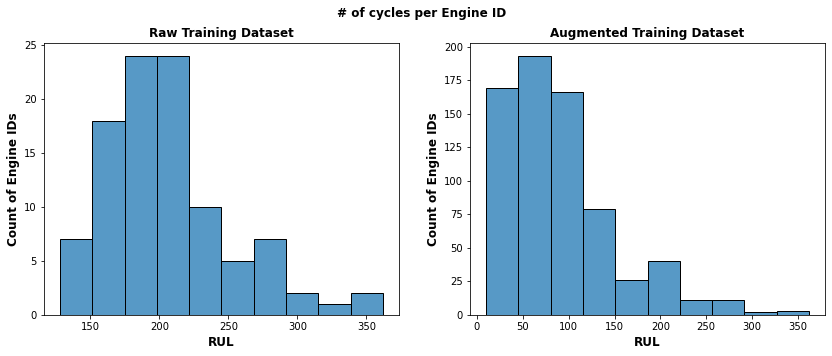

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(train.groupby('engine_id')['cycle'].max(), bins = 10, ax=ax[0])
ax[0].set_title("Raw Training Dataset", fontsize=12, fontweight = 'bold')
ax[0].set_xlabel('RUL', fontsize=12, fontweight = 'bold')
ax[0].set_ylabel('Count of Engine IDs', fontsize=12, fontweight = 'bold')

sns.histplot(aug_train.groupby('engine_id')['cycle'].max(), bins = 10, ax=ax[1])
ax[1].set_title("Augmented Training Dataset", fontsize=12, fontweight = 'bold')
ax[1].set_xlabel('RUL', fontsize=12, fontweight = 'bold')
ax[1].set_ylabel('Count of Engine IDs', fontsize=12, fontweight = 'bold')

plt.suptitle("# of cycles per Engine ID\n", fontsize=12, fontweight = 'bold')
plt.show()

## Observations:

* After normalization, the variation is features for various engine IDs across training and test datasets are comparable. 

* The variation of RUL with loading cycles for engine IDs in augmented training set resemble the varioation in the test set. 

* After Augmentation, the number of engine IDs (including newly generated) increase to 700 from 100, however the distribution of final RUL remaine similar to the original. 